In [1]:
%load_ext Cython

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import pyarrow as pa
from pyarrow import csv
import time

from tqdm import tqdm
from scipy.special import erfc

from scipy.optimize import curve_fit
from scipy import stats

from cycler import cycler
import boost_histogram as bh

import warnings
warnings.filterwarnings('ignore')

# import cm_xml_to_matplotlib as cm
# mycmap = cm.make_cmap('mellow-rainbow.xml')
# cmap = plt.get_cmap(mycmap)

from palettable.wesanderson import Zissou_5
from cycler import cycler
plt.rc('axes', prop_cycle=cycler('color', Zissou_5.mpl_colors)) 

# from gr.pygr import mlab

from lmfit.models import *
from lmfit import Model

import inspect


In [5]:
%%cython --annotate
import numpy as np
cimport numpy as np
cimport cython

def A(M,B,C):
    if (C > 0 and np.abs(B) <= 4*C):
        return M**2 + B**2/(8*C) + C 
    else:
        return M**2 + np.abs(B) - C

@cython.embedsignature(True)
cpdef model_new(x, M, b, c):
    """
    a => sigma_l + sigma_t
    b => epsilon*sigma_tt
    c => Sqrt(2epsilon(1+epsilon))* sigma_lt
    """
    f = A(M,b,c) + b * np.cos(2*x) + c * np.cos(x)
    return f

def model(x, a, b, c):
    """
    a => sigma_l + sigma_t
    b => epsilon*sigma_tt
    c => Sqrt(2epsilon(1+epsilon))* sigma_lt
    """
    f = a + b * np.cos(2*x) + c * np.cos(x)
    return f

In [6]:
inspect.signature(model_new)

ValueError: no signature found for builtin <built-in function model_new>

In [7]:
def degauss(x, A, mu, sigma, lambda1, lambda2):
    mu1 = sigma * sigma * lambda1 + x - mu
    mu2 = -sigma * sigma * lambda2 + x - mu
    ret = A * 0.5 / (1.0 / lambda1 + 1.0 / lambda2) * \
        (np.exp(0.5 * np.power(sigma * lambda1, 2) + lambda1 * (x - mu)) * erfc(mu1 / (sigma * np.sqrt(2.0))) \
         + np.exp(0.5 * np.power(sigma * lambda2, 2) - lambda2 * (x - mu)) * erfc(-mu2 / (sigma * np.sqrt(2.0))))

    return ret

def gauss(x, A, mu, sig):
    ret = np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    return A*ret

def peak(x, c):
    return np.exp(-np.power(x - c, 2) / 16.0)

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = np.max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]


In [8]:
names = ["electron_sector", "w", "q2", "theta", "phi", "mm2", "helicty", "type", "hash"]
dtype={
    "electron_sector": "int8", 
    "helicty": "int8", 
    "w": "float32", 
    "q2": "float32", 
    "theta": "float32", 
    "phi": "float32", 
    "mm2": "float32", 
    "type": "category"
}

mc_df = pd.read_csv("/Users/tylern/Data/ntuple/mc_rec_e1f.csv", names=names, index_col=False, dtype=dtype)


mc_df = mc_df[(mc_df.w > 0) & (mc_df.mm2 > 0.5) & (mc_df.mm2 < 1.5)]
mc_df['cos_theta'] = np.cos(mc_df.theta)

mc_rec = mc_df[mc_df.type == "mc_rec"]
mc_thrown = mc_df[mc_df.type == "thrown"]

del mc_df

mc_rec = mc_rec.merge(mc_thrown,left_on="hash", right_on="hash",suffixes=("","_thrown"))
mc_rec.drop(["type", "hash", "type_thrown","electron_sector_thrown","helicty_thrown"], axis=1, inplace=True)
mc_thrown.drop(["type","hash"], axis=1, inplace=True)


def read_csv(file_name):
    names = [
        "electron_sector",
        "w",
        "q2",
        "theta",
        "phi",
        "mm2",
        "helicty",
        "type",
        "hash",
    ]
    dtype = {
        "electron_sector": "int8",
        "helicty": "int8",
        "w": "float32",
        "q2": "float32",
        "theta": "float32",
        "phi": "float32",
        "mm2": "float32",
    }

    start = time.time()
    pyTable = csv.read_csv(
        file_name,
        read_options=csv.ReadOptions(use_threads=True, column_names=names),
        convert_options=csv.ConvertOptions(column_types=dtype),
    )
    stop = time.time()
    print(f"read_csv: {stop - start}")
    return pyTable.to_pandas()


rec = read_csv("/Users/tylern/Data/e1d/data/data_e1d.csv")
rec = rec[(rec.w > 0) & (rec.mm2 > 0.5) & (rec.mm2 < 2.5)]
rec.drop(["type","hash"], axis=1, inplace=True)
rec['cos_theta'] = np.cos(rec.theta).astype(np.float32)

rec.head()


read_csv: 0.3666191101074219


,electron_sector,w,q2,theta,phi,mm2,helicty,cos_theta
0,4,1.29763,2.06611,1.62744,2.266050,0.925765,-1,-0.056613
1,6,1.58639,1.75609,1.51577,3.752750,1.245410,-1,0.054999
3,5,1.35887,1.84541,1.19962,0.130738,0.770414,-1,0.362712
4,3,1.80207,1.88370,1.54578,3.099240,1.317180,0,0.025014
5,1,1.19428,2.20803,1.49875,5.470450,1.014120,-1,0.071984


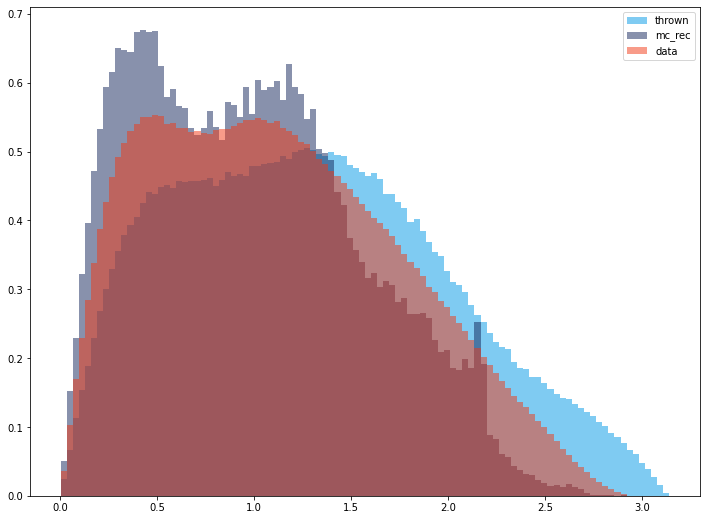

In [9]:
fig, ax = plt.subplots(figsize=(12,9))

ax.hist(mc_thrown.theta.to_numpy(), bins=100,alpha=0.5,  label='thrown', density=True, 
        range=(np.min(mc_thrown.theta),np.max(mc_thrown.theta)))
ax.hist(mc_rec.theta.to_numpy(), bins=100, alpha=0.5, label='mc_rec', density=True, 
        range=(np.min(mc_thrown.theta),np.max(mc_thrown.theta)))

ax.hist(rec.theta, bins=100, alpha=0.5, label='data', density=True, 
        range=(np.min(mc_thrown.theta),np.max(mc_thrown.theta)))

ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

#ax.hist(mc_rec.w_thrown-mc_rec.w, bins=1000, range=(-0.05,0.05), alpha=0.5,  label='thrown', density=True)
#ax.hist(mc_rec.q2_thrown-mc_rec.q2, bins=1000, range=(-0.05,0.05), alpha=0.5,  label='thrown', density=True)
#ax.hist(mc_rec.theta_thrown-mc_rec.theta, bins=1000, range=(-0.05,0.05), alpha=0.5,  label='thrown', density=True)
ax.hist(mc_rec.phi_thrown.to_numpy(), bins=100, alpha=0.5,  label='$\phi^{*}$ thrown', density=True)
ax.hist(mc_rec.phi.to_numpy(), bins=100, alpha=0.5,  label='$\phi^{*}$ rec', density=True)
ax.hist(mc_thrown.phi.to_numpy(), bins=100, alpha=0.5,  label='$\phi^{*}$ data', density=True)


ax.legend()

plt.show()



In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

ax.hist(mc_thrown.mm2.to_numpy(), bins=100,alpha=0.5,  label='thrown', density=True,
       range=(0.8,1.0))
ax.hist(mc_rec.mm2.to_numpy(), bins=100, alpha=0.5, label='mc_rec', density=True,
        range=(0.8,1.0))

ax.hist(rec.mm2.to_numpy(), bins=100, alpha=0.5, label='mc_rec', density=True,
        range=(0.8,1.0))

ax.legend()
plt.show()

In [10]:
def mm_cut(df):
    NSIGMA = 4
    data = {}
    for sec in range(1,7):
        plt.figure(figsize=(12,9))
#         y,x = np.histogram(df[df.electron_sector == sec].mm2.to_numpy(), bins=500, density=True)
        
#         hist = bh.Histogram(bh.axis.Regular(500, 0.5, 1.5))
#         hist.fill(df[df.electron_sector == sec].mm2.to_numpy())
#         y, x = hist.to_numpy()
#         y = y/np.max(y)
        
        y,x = bh.numpy.histogram(df[df.electron_sector == sec].mm2.to_numpy(), bins=100, density=True)

        x=(x[1:]+x[:-1])/2

        plt.errorbar(x,y/np.max(y),yerr=stats.sem(y/np.max(y)), fmt='.', zorder=1)

        
        peak = PseudoVoigtModel(prefix="peak_")
        pars = peak.guess(y, x=x)
        background = GaussianModel(prefix="back_")
        pars.update(background.make_params())
        model = peak * background
        
        out = model.fit(y, pars, x=x)
        
        xs= np.linspace(0.5,1.5,1000)
        plt.plot(xs, out.eval(params=out.params, x=xs)/np.max(out.eval(params=out.params, x=xs)))
        comps = out.eval_components(x=xs)      
#         dely = out.eval_uncertainty(x=xs, sigma=1)
#         dely = dely/np.max(dely)
#         yss = out.eval(params=out.params, x=xs)
#         yss = yss/np.max(yss)
#         plt.fill_between(xs, yss-dely, yss+dely, color='#888888')
        plt.plot(xs, comps['peak_']/np.max(comps['peak_']), alpha=0.4)
        
        plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_fwhm'])
        plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_fwhm'])        
        
        
        plt.show()

        data[sec] = (out.params['peak_center']-NSIGMA*out.params['peak_fwhm'], 
                     out.params['peak_center']+NSIGMA*out.params['peak_fwhm'])
        
#         print('{', end='')
#         for x in popt_g:
#             print(f' {x:.20f},', end='')
#         print('}')

    return data

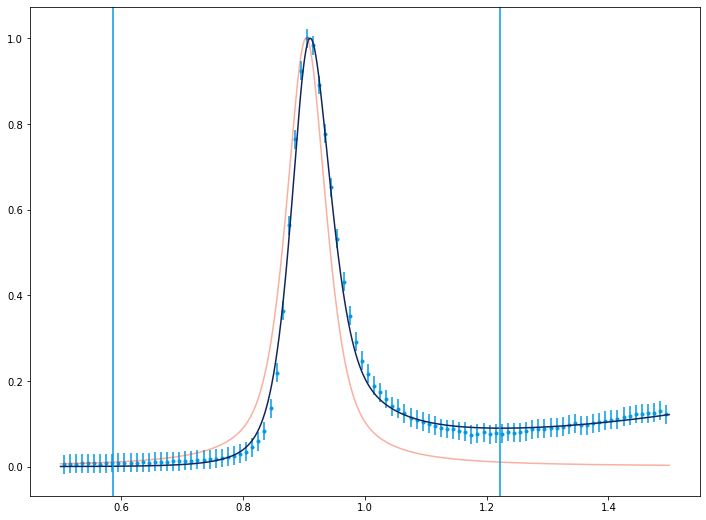

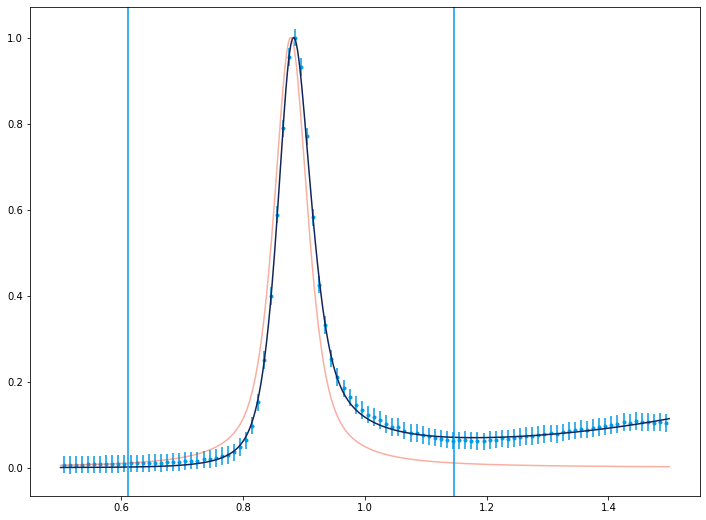

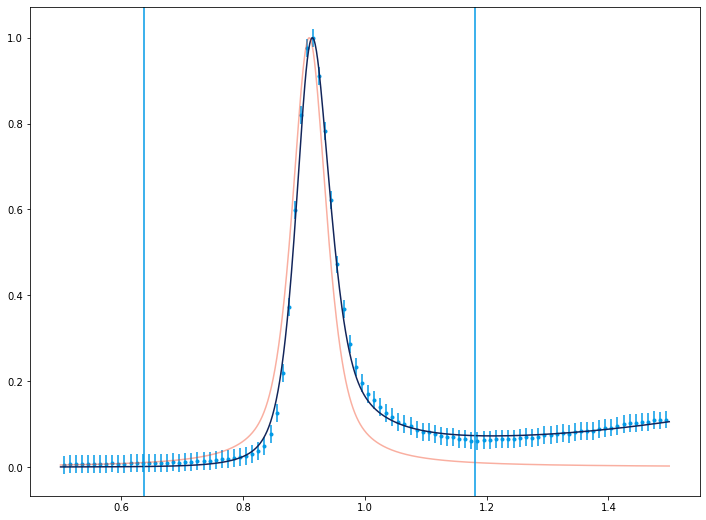

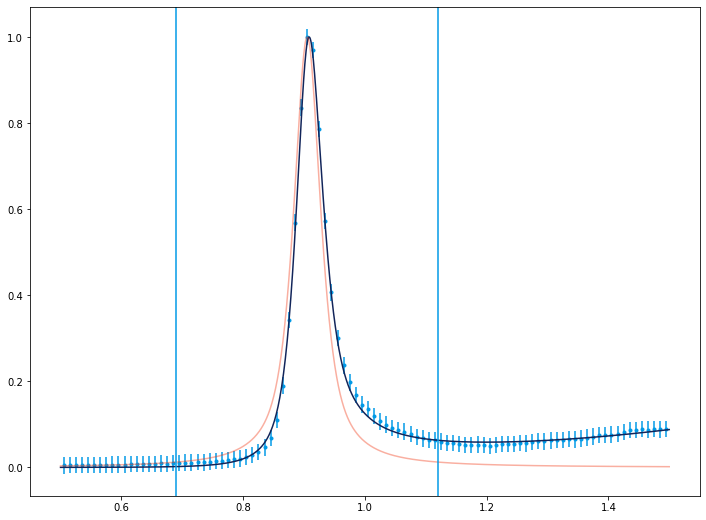

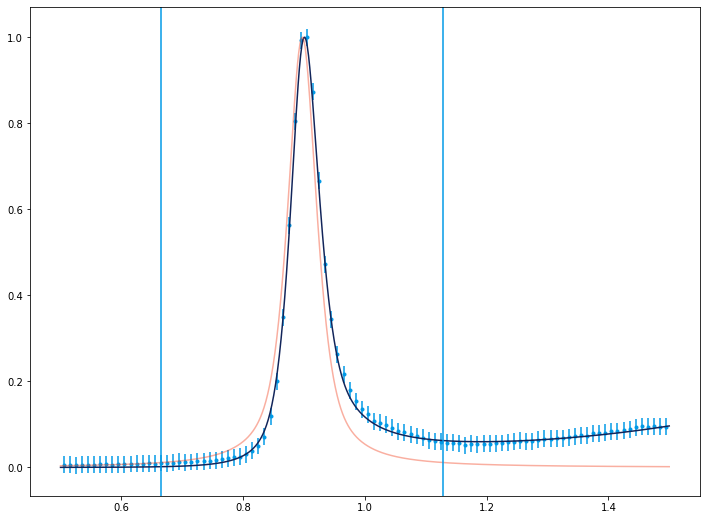

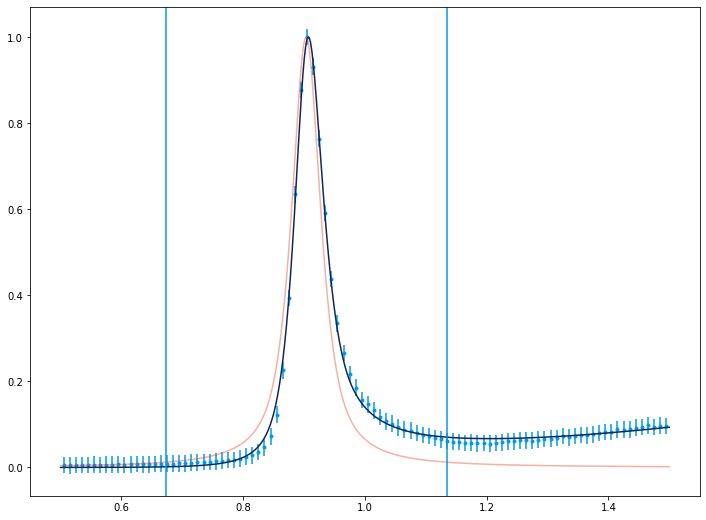

In [11]:
sector_cuts = mm_cut(rec)

In [ ]:
cuts = False
mc_cuts = True

for sec, min_max in sector_cuts.items():
    cuts |= ((rec.electron_sector == sec) & (rec.mm2 >= min_max[0]) &  (rec.mm2 <= min_max[1]))
    mc_cuts |= ((mc_rec.electron_sector == sec) & (mc_rec.mm2 >= min_max[0]) &  (mc_rec.mm2 <= min_max[1]))
    
rec = rec[cuts]
mc_rec = mc_rec[mc_cuts]

In [ ]:
# mc_rec = mc_rec[["w","q2","mm2","cos_theta","phi","helicty"]].copy(deep=True)
# mc_thrown = mc_thrown[["w","q2","mm2","cos_theta","phi","helicty"]].copy(deep=True)
# rec = rec[["w","q2","mm2","cos_theta","phi","helicty"]].copy(deep=True)

# rec.head()

In [ ]:
w_bins = np.arange(1.0, 1.825, 0.025)
q2_bins = np.arange(1.0, 2.5, 0.5)
theta_bins = np.arange(-1.0, 1.25, 0.25)

mc_rec['w_bin'] = pd.cut(mc_rec['w'], bins=w_bins, include_lowest=True)
mc_rec['q2_bin'] = pd.cut(mc_rec['q2'], bins=q2_bins, include_lowest=True)
mc_rec['theta_bin'] = pd.cut(mc_rec['cos_theta'], bins=theta_bins, include_lowest=True)


mc_thrown['w_bin'] = pd.cut(mc_thrown['w'], bins=w_bins, include_lowest=True)
mc_thrown['q2_bin'] = pd.cut(mc_thrown['q2'], bins=q2_bins, include_lowest=True)
mc_thrown['theta_bin'] = pd.cut(mc_thrown['cos_theta'], bins=theta_bins, include_lowest=True)

rec['w_bin'] = pd.cut(rec['w'], bins=w_bins, include_lowest=True)
rec['q2_bin'] = pd.cut(rec['q2'], bins=q2_bins, include_lowest=True)
rec['theta_bin'] = pd.cut(rec['cos_theta'], bins=theta_bins, include_lowest=True)

mc_rec.dropna(inplace=True)
mc_thrown.dropna(inplace=True)
rec.dropna(inplace=True)

In [ ]:
plt.hist2d(rec.w.to_numpy(),rec.q2.to_numpy(),bins=(len(w_bins),len(q2_bins)))
plt.show()

In [ ]:
plt.hist(mc_rec.mm2.to_numpy(), bins=500)
plt.show()

In [ ]:
plt.hist2d(mc_thrown.w.to_numpy(),mc_thrown.q2.to_numpy(), cmap=cmap, bins=200, range=[[1.0,1.8],[1.0,2.2]])
plt.title("Thrown W vs $Q^2$")
plt.show()

plt.hist2d(mc_rec.w.to_numpy(),mc_rec.q2.to_numpy(), cmap=cmap, bins=200, range=[[1.0,1.8],[1.0,2.2]])
plt.title("MC rec W vs $Q^2$")
plt.show()

plt.hist2d(rec.w.to_numpy(), rec.q2.to_numpy(), cmap=cmap, bins=100, range=[[1.0,1.8],[1.0,2.2]])
plt.title("Data W vs $Q^2$")
plt.show()

plt.hist(rec.w.to_numpy(), bins=100, range=[1.0,1.8])
plt.title("Data W vs $Q^2$")
plt.show()

In [ ]:
def draw_xsection(rec, mc_rec, thrown, func):
    xs = np.linspace(0,2*np.pi,100)
    for w in np.unique(rec.w_bin):
        for q2 in np.unique(rec.q2_bin):
            for cos_t in np.unique(rec.theta_bin):
                rec_cut = ((w == rec.w_bin) & (q2 == rec.q2_bin) & (cos_t == rec.theta_bin))
                mc_rec_cut = ((w == mc_rec.w_bin) & (q2 == mc_rec.q2_bin) & (cos_t == mc_rec.theta_bin))
                thrown_cut = ((w == thrown.w_bin) & (q2 == thrown.q2_bin) & (cos_t == thrown.theta_bin))
                
                data = rec[rec_cut]
                mc_rec_data = mc_rec[mc_rec_cut]
                thrown_data = thrown[thrown_cut]
                fig, ax = plt.subplots(2, 2, figsize=(12,9))
                    
                fig.suptitle(f"W={w},\t$Q^2$={q2},\tcos($\Theta$)={cos_t}")
                for bins in range(10,11):
                    data_y, data_x = bh.numpy.histogram(data.phi.to_numpy(), bins=bins, range=(0, 2*np.pi))
                    x = (data_x[1:]+data_x[:-1])/2.0
                    mc_rec_y, _ = bh.numpy.histogram(mc_rec_data.phi.to_numpy(), bins=bins, range=(0, 2*np.pi))
                    thrown_y, _ = bh.numpy.histogram(thrown_data.phi.to_numpy(), bins=bins, range=(0, 2*np.pi))
                                    
                    # Change 0's to 1 for division
                    thrown_y = np.where(thrown_y == 0, 1, thrown_y)
                    mc_rec_y = np.where(mc_rec_y == 0, 1, mc_rec_y)
                
                    
                    ax[0][0].errorbar(x, thrown_y, marker='.',yerr=stats.sem(thrown_y), linestyle='', 
                                      label='thrown', c=Zissou_5.mpl_colors[0])
                    ax[0][0].errorbar(x, mc_rec_y, marker='.',yerr=stats.sem(mc_rec_y), linestyle='', 
                                      label='mc_rec', c=Zissou_5.mpl_colors[1])
                    ax[0][1].errorbar(x, data_y, yerr=stats.sem(data_y), marker='.', linestyle='', 
                                      label='data', c=Zissou_5.mpl_colors[2])
                
                    acceptance = thrown_y/mc_rec_y
                    ax[1][0].errorbar(x, acceptance, yerr=stats.sem(acceptance),
                                      marker='.', linestyle='',
                                      label='acceptance', c=Zissou_5.mpl_colors[3])
                
                    y = data_y * np.nan_to_num(acceptance)
                
                    popt, pcov = curve_fit(func, x, y, maxfev=8000)
                    ax[1][1].errorbar(x, y, yerr=stats.sem(y), marker='.', 
                                      linestyle='', zorder=1,
                                      label='corrected', c=Zissou_5.mpl_colors[4])
                    
                    
                    ax[1][1].plot(xs, func(xs, *popt), linewidth=2.0)
                

                fig.legend()
                plt.show()



In [ ]:
draw_xsection(rec, mc_rec, mc_thrown, model)

In [ ]:
draw_xsection(rec, mc_rec, mc_thrown, model_new)

In [ ]:
plt.hist(mc_thrown.w, bins=200, alpha=0.2)
plt.hist(mc_rec.w, bins=200, alpha=0.5)
plt.show()

In [ ]:
rec.head()

In [ ]:
%%timeit
y,x = np.histogram(rec.mm2, bins=500, density=True)

In [ ]:
%%timeit
y,x = np.histogram(rec.mm2.to_numpy(), bins=500, density=True)

In [ ]:
%%timeit
hist = bh.Histogram(bh.axis.Regular(500, 0.5, 1.5))
hist.fill(rec.mm2.to_numpy())
y, x = hist.to_numpy()
y = y/np.max(y)

In [ ]:
%%timeit
y,x = bh.numpy.histogram(rec.mm2.to_numpy(), bins=500, density=True)

In [ ]:
y,x = bh.numpy.histogram(rec.mm2.to_numpy(), bins=120, density=True)
mlab.size((2500,1500))
x = (x[1:]+x[:-1])/2.0
mlab.scatter(x,y)

In [ ]:
print(rec.w_bin[7].left)

In [ ]:
Zissou_5.mpl_colors[0]